In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [17]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual2.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [4]:
function r(s)
    range = s[1]
    if range > 150 return -.2 end  # reward to not lose track of contact
    if range <= 10 return -10 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [5]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [6]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [18]:
totals = [0.0]
θ = zeros(length(grid),6);
e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [19]:

N = 400
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.3
γ = 0.98
ϵ = 0.3
x = [20, 60, 90, 1, 1];
λ = 0.98
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0


0

In [ ]:
## Q-learning loop
#plots = []
#betas = Deque{Array}()
#β = zeros(length(grid),6);
# this version uses Greg's weighted grid 3 -- averages before interpolating
# local approximation instead of global approximation

epochs = 5000
epochsize = 500

total = 0

k = 15
last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_3(b))
uu = softmax_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], k, rng)
u = uu[1]
rando = 0
rando += uu[2]

for i in 1:(epochsize*epochs)
    counter += 1
    
    e[:,u] += ξ
    last = transpose(θ[:,u])*ξ
    
    # choose next action
    uu = softmax_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], k, rng)
    u = uu[1]
    rando += uu[2]
    a_star = uu[3]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_3(b))
     
    total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    cur = transpose(θ[:,a_star])*ξ
    
    δ = rew + γ * cur - last
    
    θ += α * δ * e
    #if uu[2] == 0
    e *= γ * λ
    #else
    #    e = sparse(zeros(length(grid),6))
    #end
    
        
    if counter % epochsize == 0
        push!(totals, total*500/epochsize)
        println("--------- CURRENT: ", round(total*500/epochsize, sigdigits=4), " AVG: ", round(mean(totals), sigdigits=4), " Epoch: ", 
            trunc(Int, counter/epochsize), " -----------")
        total = 0
        rando = 0
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        ξ = sparse(weighted_grid_3(b))
        running_avg = mean(totals)
        if running_avg > 0 
            k = max(running_avg, 1)
        else
            k = 1
        end
    end
    if counter % (epochsize*5) == 0
        thetaframe = DataFrame(θ)
        CSV.write("current475.csv", thetaframe)
    end
    
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: -37.0 AVG: -18.5 Epoch: 1 -----------
--------- CURRENT: -82.0 AVG: -39.67 Epoch: 2 -----------
--------- CURRENT: -333.8 AVG: -113.2 Epoch: 3 -----------
--------- CURRENT: -35.8 AVG: -97.72 Epoch: 4 -----------
--------- CURRENT: -6.7 AVG: -82.55 Epoch: 5 -----------
--------- CURRENT: -44.2 AVG: -77.07 Epoch: 6 -----------
--------- CURRENT: 35.3 AVG: -63.02 Epoch: 7 -----------
--------- CURRENT: -172.2 AVG: -75.16 Epoch: 8 -----------
--------- CURRENT: -53.2 AVG: -72.96 Epoch: 9 -----------
--------- CURRENT: 24.5 AVG: -64.1 Epoch: 10 -----------
--------- CURRENT: 43.1 AVG: -55.17 Epoch: 11 -----------
--------- CURRENT: -90.4 AVG: -57.88 Epoch: 12 -----------
--------- CURRENT: 50.0 AVG: -50.17 Epoch: 13 -----------
--------- CURRENT: 7.8 AVG: -46.31 Epoch: 14 -----------
--------- CURRENT: 50.0 AVG: -40.29 Epoch: 15 -----------
--------- CURRENT: 26.6 AVG: -36.35 Epoch: 16 -----------
--------- CURRENT: 50.0 AVG: -31.56 Epoch: 17 -----------
--------- CURREN

--------- CURRENT: 32.0 AVG: -26.85 Epoch: 141 -----------
--------- CURRENT: -59.8 AVG: -27.08 Epoch: 142 -----------
--------- CURRENT: -75.7 AVG: -27.42 Epoch: 143 -----------
--------- CURRENT: -52.0 AVG: -27.59 Epoch: 144 -----------
--------- CURRENT: 36.5 AVG: -27.15 Epoch: 145 -----------
--------- CURRENT: 49.1 AVG: -26.63 Epoch: 146 -----------
--------- CURRENT: -527.8 AVG: -30.02 Epoch: 147 -----------
--------- CURRENT: -94.0 AVG: -30.45 Epoch: 148 -----------
--------- CURRENT: 9.2 AVG: -30.18 Epoch: 149 -----------
--------- CURRENT: -62.8 AVG: -30.4 Epoch: 150 -----------
--------- CURRENT: -76.6 AVG: -30.7 Epoch: 151 -----------
--------- CURRENT: -93.1 AVG: -31.11 Epoch: 152 -----------
--------- CURRENT: 50.0 AVG: -30.58 Epoch: 153 -----------
--------- CURRENT: -94.9 AVG: -31.0 Epoch: 154 -----------
--------- CURRENT: -73.6 AVG: -31.27 Epoch: 155 -----------
--------- CURRENT: -62.5 AVG: -31.47 Epoch: 156 -----------
--------- CURRENT: -91.4 AVG: -31.85 Epoch: 157 

--------- CURRENT: -58.0 AVG: -24.45 Epoch: 279 -----------
--------- CURRENT: -58.0 AVG: -24.57 Epoch: 280 -----------
--------- CURRENT: -74.8 AVG: -24.75 Epoch: 281 -----------
--------- CURRENT: -8.5 AVG: -24.69 Epoch: 282 -----------
--------- CURRENT: 14.0 AVG: -24.56 Epoch: 283 -----------
--------- CURRENT: 48.8 AVG: -24.3 Epoch: 284 -----------
--------- CURRENT: -92.8 AVG: -24.54 Epoch: 285 -----------
--------- CURRENT: 50.0 AVG: -24.28 Epoch: 286 -----------
--------- CURRENT: -51.7 AVG: -24.38 Epoch: 287 -----------
--------- CURRENT: -55.0 AVG: -24.48 Epoch: 288 -----------
--------- CURRENT: 50.0 AVG: -24.22 Epoch: 289 -----------
--------- CURRENT: -17.8 AVG: -24.2 Epoch: 290 -----------
--------- CURRENT: 49.1 AVG: -23.95 Epoch: 291 -----------
--------- CURRENT: -181.2 AVG: -24.49 Epoch: 292 -----------
--------- CURRENT: -129.2 AVG: -24.84 Epoch: 293 -----------
--------- CURRENT: -40.9 AVG: -24.9 Epoch: 294 -----------
--------- CURRENT: 0.5 AVG: -24.81 Epoch: 295 -

--------- CURRENT: -87.1 AVG: -25.69 Epoch: 417 -----------
--------- CURRENT: -74.2 AVG: -25.81 Epoch: 418 -----------
--------- CURRENT: 1.1 AVG: -25.75 Epoch: 419 -----------
--------- CURRENT: 50.0 AVG: -25.57 Epoch: 420 -----------
--------- CURRENT: -74.1 AVG: -25.68 Epoch: 421 -----------
--------- CURRENT: -45.4 AVG: -25.73 Epoch: 422 -----------
--------- CURRENT: -101.5 AVG: -25.91 Epoch: 423 -----------
--------- CURRENT: 33.2 AVG: -25.77 Epoch: 424 -----------
--------- CURRENT: -85.3 AVG: -25.91 Epoch: 425 -----------
--------- CURRENT: -35.5 AVG: -25.93 Epoch: 426 -----------
--------- CURRENT: -81.3 AVG: -26.06 Epoch: 427 -----------
--------- CURRENT: 50.0 AVG: -25.88 Epoch: 428 -----------
--------- CURRENT: -52.9 AVG: -25.94 Epoch: 429 -----------
--------- CURRENT: 13.1 AVG: -25.85 Epoch: 430 -----------
--------- CURRENT: -40.9 AVG: -25.89 Epoch: 431 -----------
--------- CURRENT: -53.2 AVG: -25.95 Epoch: 432 -----------
--------- CURRENT: 11.0 AVG: -25.87 Epoch: 43

--------- CURRENT: -66.1 AVG: -25.25 Epoch: 555 -----------
--------- CURRENT: -71.5 AVG: -25.33 Epoch: 556 -----------
--------- CURRENT: -40.9 AVG: -25.36 Epoch: 557 -----------
--------- CURRENT: 50.0 AVG: -25.22 Epoch: 558 -----------
--------- CURRENT: -105.4 AVG: -25.37 Epoch: 559 -----------
--------- CURRENT: -70.6 AVG: -25.45 Epoch: 560 -----------
--------- CURRENT: 35.6 AVG: -25.34 Epoch: 561 -----------
--------- CURRENT: 4.4 AVG: -25.29 Epoch: 562 -----------
--------- CURRENT: -60.4 AVG: -25.35 Epoch: 563 -----------
--------- CURRENT: 50.0 AVG: -25.22 Epoch: 564 -----------
--------- CURRENT: 44.9 AVG: -25.09 Epoch: 565 -----------
--------- CURRENT: -22.6 AVG: -25.09 Epoch: 566 -----------
--------- CURRENT: -101.5 AVG: -25.22 Epoch: 567 -----------
--------- CURRENT: -13.9 AVG: -25.2 Epoch: 568 -----------
--------- CURRENT: -67.9 AVG: -25.28 Epoch: 569 -----------
--------- CURRENT: -97.3 AVG: -25.4 Epoch: 570 -----------
--------- CURRENT: -76.9 AVG: -25.49 Epoch: 57

--------- CURRENT: -42.7 AVG: -26.41 Epoch: 693 -----------
--------- CURRENT: -51.0 AVG: -26.45 Epoch: 694 -----------
--------- CURRENT: 50.0 AVG: -26.34 Epoch: 695 -----------
--------- CURRENT: 41.9 AVG: -26.24 Epoch: 696 -----------
--------- CURRENT: 32.3 AVG: -26.16 Epoch: 697 -----------
--------- CURRENT: -3.4 AVG: -26.12 Epoch: 698 -----------
--------- CURRENT: 32.0 AVG: -26.04 Epoch: 699 -----------
--------- CURRENT: 50.0 AVG: -25.93 Epoch: 700 -----------
--------- CURRENT: 50.0 AVG: -25.83 Epoch: 701 -----------
--------- CURRENT: 48.2 AVG: -25.72 Epoch: 702 -----------
--------- CURRENT: 10.4 AVG: -25.67 Epoch: 703 -----------
--------- CURRENT: -14.8 AVG: -25.65 Epoch: 704 -----------
--------- CURRENT: -37.3 AVG: -25.67 Epoch: 705 -----------
--------- CURRENT: 50.0 AVG: -25.56 Epoch: 706 -----------
--------- CURRENT: -31.0 AVG: -25.57 Epoch: 707 -----------
--------- CURRENT: -202.5 AVG: -25.82 Epoch: 708 -----------
--------- CURRENT: -50.2 AVG: -25.85 Epoch: 709 -

--------- CURRENT: -39.4 AVG: -24.63 Epoch: 831 -----------
--------- CURRENT: -27.4 AVG: -24.64 Epoch: 832 -----------
--------- CURRENT: 50.0 AVG: -24.55 Epoch: 833 -----------
--------- CURRENT: -37.9 AVG: -24.56 Epoch: 834 -----------
--------- CURRENT: -28.9 AVG: -24.57 Epoch: 835 -----------
--------- CURRENT: -68.5 AVG: -24.62 Epoch: 836 -----------
--------- CURRENT: -81.7 AVG: -24.69 Epoch: 837 -----------
--------- CURRENT: 50.0 AVG: -24.6 Epoch: 838 -----------
--------- CURRENT: -71.2 AVG: -24.66 Epoch: 839 -----------
--------- CURRENT: -97.6 AVG: -24.74 Epoch: 840 -----------
--------- CURRENT: -85.3 AVG: -24.82 Epoch: 841 -----------
--------- CURRENT: 50.0 AVG: -24.73 Epoch: 842 -----------
--------- CURRENT: 50.0 AVG: -24.64 Epoch: 843 -----------
--------- CURRENT: 18.5 AVG: -24.59 Epoch: 844 -----------
--------- CURRENT: -48.1 AVG: -24.61 Epoch: 845 -----------
--------- CURRENT: -71.2 AVG: -24.67 Epoch: 846 -----------
--------- CURRENT: 48.2 AVG: -24.58 Epoch: 847

In [54]:
θ = convert(Matrix, CSV.read("current473.csv"))

30420×6 Array{Float64,2}:
 -4.06072   0.0         -12.7153    0.0           -5.40007   0.0        
 -5.74517   0.0         -15.7834    0.0           -8.13179   0.0        
 -3.42704   0.0         -19.1464    0.0341359    -11.5613    0.0        
 -1.51409   0.0         -23.0423    0.0183138     -9.30633   0.0        
 -0.193465  0.0157158    -1.28939   0.00300404     1.32795   0.0        
  0.565902  0.00673533    0.684805  0.0            0.686657  0.0        
  0.808509  0.0           2.81592   0.00685856     0.59149   0.0        
  1.29874   0.0247135     1.06388   0.000762062    0.405348  0.000318762
  3.98132   0.0255353     0.240398  0.0            0.411339  0.0040335  
  5.7998    0.00871109    0.425003  0.0            0.405973  0.000776428
  4.92557   0.018768      0.61746   0.0            0.590034  0.0        
  5.92907   0.0385562     0.547618  0.0            0.593071  0.0        
  5.24864   0.00124996    0.443488  0.0            0.594687  0.0        
  ⋮                      

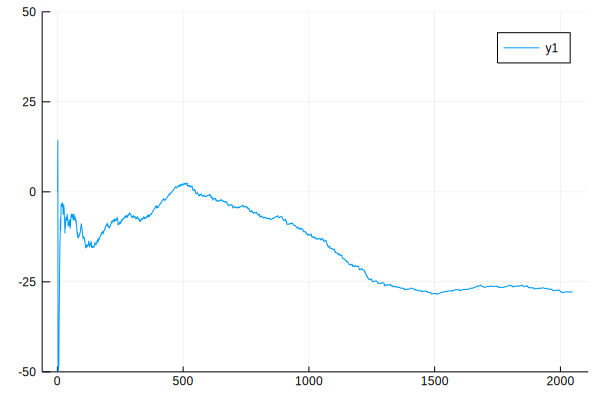

In [19]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (-50,50))

In [11]:
#thetaframe = CSV.read("0.44_theta_12.1_1.csv");


In [12]:
#θ = convert(Matrix, thetaframe)

In [25]:
thetaframe = DataFrame(θ)
CSV.write("0.44_theta_11.28_1", thetaframe)

"0.44_theta_11.28_1"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5